In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../Data/co2_mm_mlo.csv')

In [5]:
df.head(3)

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50


In [7]:
date_dict = dict(year = df['year'], month=df['month'], day=1)

In [9]:
df['date'] = pd.to_datetime(date_dict)

In [12]:
df = df.drop(['year', 'month', 'decimal_date'], axis=1)

In [14]:
df = df.set_index('date')

In [16]:
df.index.freq='MS'

In [17]:
df.head(3)

,average,interpolated
date,,
1958-03-01,315.71,315.71
1958-04-01,317.45,317.45
1958-05-01,317.50,317.50


In [18]:
# EDA

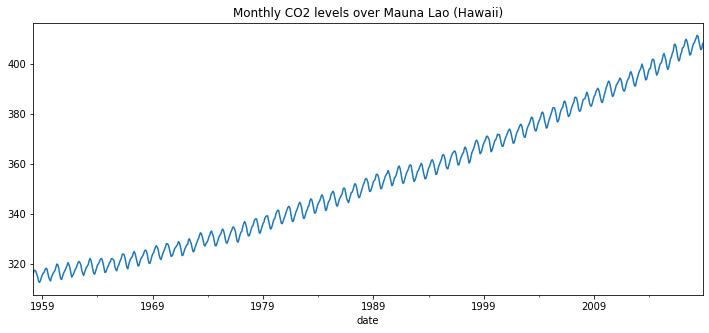

In [20]:
df['interpolated'].plot()
plt.title('Monthly CO2 levels over Mauna Lao (Hawaii)');

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

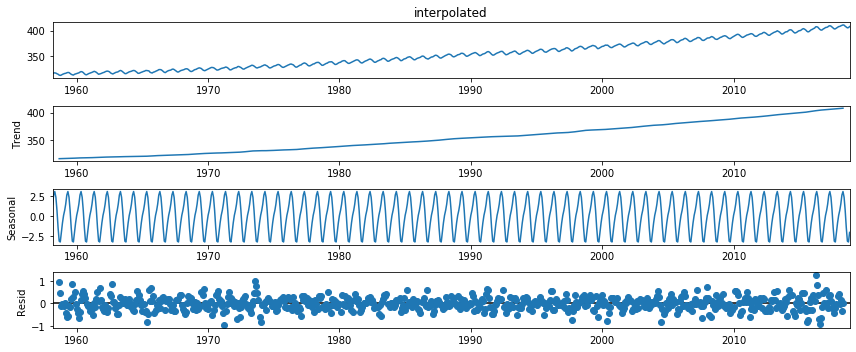

In [24]:
seasonal_decompose(df['interpolated']).plot();

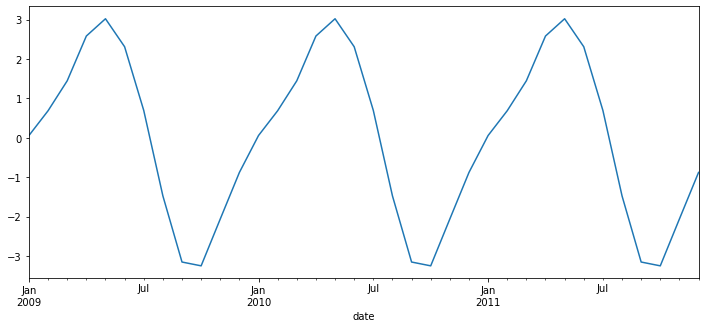

In [30]:
seasonal_decompose(df['interpolated']).seasonal['2009':'2011'].plot()
# m = 12
# yearly peaks

In [25]:
# Auto arima

In [26]:
from pmdarima import auto_arima

In [31]:
auto_arima(df['interpolated'], start_p=0, start_q=0, seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  729
Model:             SARIMAX(4, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -204.034
Date:                                 Sat, 04 Jul 2020   AIC                            428.069
Time:                                         12:21:11   BIC                            473.972
Sample:                                              0   HQIC                           445.781
                                                 - 729                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.402      0.688      -0.001       0.001
ar.L1         -0.3411      0.035     -9.684      0.000      -0.410      -0.272
ar.L2         -0.1396      0.033     -4.210      0.000      -0.205      -0.075
ar.L3         -0.1492      0.035     -4.243      0.000      -0.218      -0.080
ar.L4         -0.0986      0.028     -3.522      0.000      -0.154      -0.044
ar.S.L12       0.0301      0.049      0.620      0.535      -0.065       0.125
ar.S.L24       0.9692      0.048     19.984      0.000       0.874       1.064
ma.S.L12       0.1235      0.070      1.767      0.077      -0.013       0.260
ma.S.L24      -0.8572      0.054    -15.743      0.000      -0.964      -0.750
sigma2         0.0947      0.005     18.920      0.000       0.085       0.104
===================================================================================
Ljung-Box (Q):                       43.57   Jarque-Bera (JB):                 3.69
Prob(Q):                              0.32   Prob(JB):                         0.16
Heteroskedasticity (H):               1.13   Skew:                             0.01
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Train test split

In [33]:
len(df)

729

In [43]:
train = df.iloc[:718]
test = df.iloc[718:]

In [44]:
len(train), len(test)

(718, 11)

In [56]:
# Model

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [46]:
model = SARIMAX(train['interpolated'],order=(4,1,0), seasonal_order=(2, 0, [1, 2], 12)).fit()

In [47]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            interpolated   No. Observations:                  718
Model:             SARIMAX(4, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -199.956
Date:                                 Sat, 04 Jul 2020   AIC                            417.911
Time:                                         12:27:02   BIC                            459.087
Sample:                                     03-01-1958   HQIC                           433.810
                                          - 12-01-2017                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3517      0.036     -9.790      0.000      -0.422      -0.281
ar.L2         -0.1465      0.036     -4.118      0.000      -0.216      -0.077
ar.L3         -0.1432      0.034     -4.223      0.000      -0.210      -0.077
ar.L4         -0.0980      0.031     -3.161      0.002      -0.159      -0.037
ar.S.L12       0.0331      0.044      0.747      0.455      -0.054       0.120
ar.S.L24       0.9662      0.044     21.795      0.000       0.879       1.053
ma.S.L12       0.1217      0.070      1.749      0.080      -0.015       0.258
ma.S.L24      -0.8569      0.057    -15.105      0.000      -0.968      -0.746
sigma2         0.0942      0.005     18.704      0.000       0.084       0.104
===================================================================================
Ljung-Box (Q):                       45.38   Jarque-Bera (JB):                 4.23
Prob(Q):                              0.26   Prob(JB):                         0.12
Heteroskedasticity (H):               1.14   Skew:                             0.01
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
result = model.predict(start=len(train), end=len(train) +len(test) -1, typ='levels', dynamic=False).rename('SARIMA Predictions')

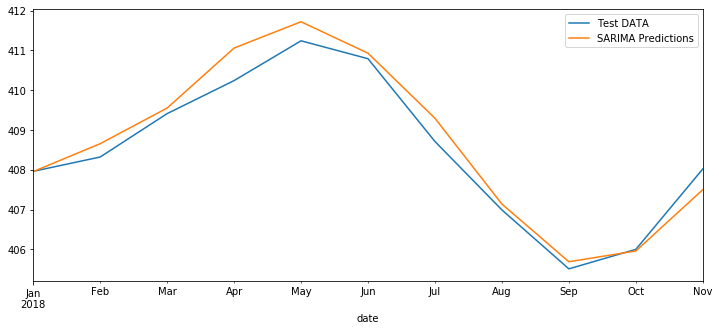

In [51]:
test['interpolated'].plot(label='Test DATA')
result.plot()
plt.legend();

In [52]:
from statsmodels.tools.eval_measures import rmse

In [54]:
print('RMSE: {}'.format(rmse(test['interpolated'], result)))

RMSE: 0.3947496456959445


In [55]:
test['interpolated'].mean()

408.4718181818182

# Retrain the model on the full data, and forecast the future

In [57]:
model = SARIMAX(df['interpolated'],order=(4,1,0), seasonal_order=(2, 0, [1, 2], 12)).fit()

In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            interpolated   No. Observations:                  729
Model:             SARIMAX(4, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -203.966
Date:                                 Sat, 04 Jul 2020   AIC                            425.933
Time:                                         12:31:36   BIC                            467.246
Sample:                                     03-01-1958   HQIC                           441.874
                                          - 11-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3534      0.035    -10.201      0.000      -0.421      -0.285
ar.L2         -0.1458      0.038     -3.888      0.000      -0.219      -0.072
ar.L3         -0.1369      0.036     -3.853      0.000      -0.207      -0.067
ar.L4         -0.1054      0.028     -3.773      0.000      -0.160      -0.051
ar.S.L12       0.0305      0.044      0.690      0.490      -0.056       0.117
ar.S.L24       0.9688      0.044     21.922      0.000       0.882       1.055
ma.S.L12       0.1245      0.070      1.776      0.076      -0.013       0.262
ma.S.L24      -0.8608      0.060    -14.302      0.000      -0.979      -0.743
sigma2         0.0945      0.005     17.810      0.000       0.084       0.105
===================================================================================
Ljung-Box (Q):                       43.32   Jarque-Bera (JB):                 3.92
Prob(Q):                              0.33   Prob(JB):                         0.14
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
forecast = model.predict(start=len(df), end=len(df)+11, typ='levels').rename('SARIMA Forecast')

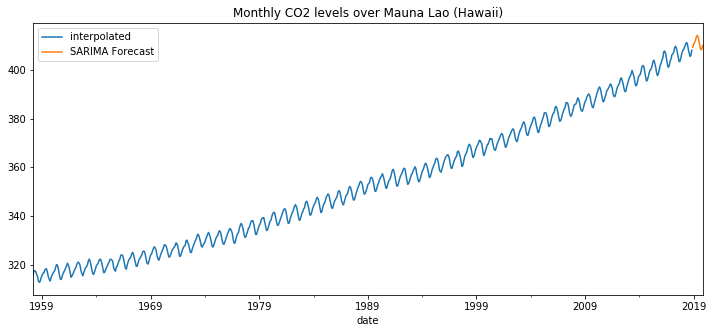

In [62]:
df['interpolated'].plot()
plt.title('Monthly CO2 levels over Mauna Lao (Hawaii)')
forecast.plot()
plt.legend();

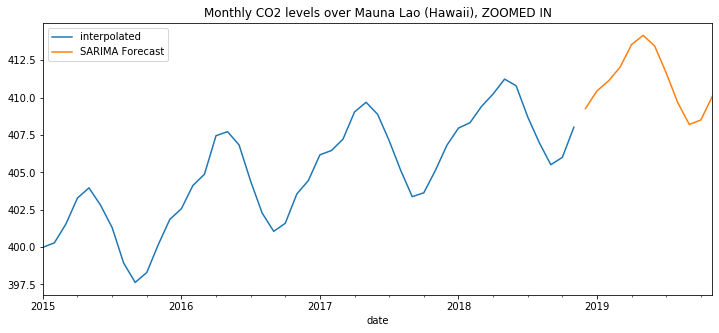

In [65]:
df['interpolated']['2015':].plot()
plt.title('Monthly CO2 levels over Mauna Lao (Hawaii), ZOOMED IN')
forecast.plot()
plt.legend();